<a href="https://colab.research.google.com/github/averyrair/ChessBAKEN/blob/main/PositionEvaluation/EvaluatorBAKEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install chess
!pip install stockfish
!apt install stockfish

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
stockfish is already the newest version (14.1-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [16]:
# @title Get board positions from inputted file

import chess.pgn
import csv

# Open PGN file
f = 'KingBase2019-A80-A99.pgn'
pgn = open(f, encoding='latin-1')

# Prepare CSV file
with open("game_positions_mini.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["pos", "turn", "result"])  # header

    game_count = 0
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break  # No more games

        result_str = game.headers.get("Result", "*")
        if result_str == "1-0":
            result = 1
        elif result_str == "0-1":
            result = -1
        elif result_str == "1/2-1/2":
            result = 0
        else:
            continue  # Skip games with unknown result

        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            pos = board.fen().split()[0]
            turn = 1 if board.turn == chess.WHITE else 0
            writer.writerow([pos, turn, result])

        game_count += 1
        if game_count % 100 == 0:
            print(f"Processed {game_count} games...")
        if game_count == 500:
            break

print("Done.")

Processed 100 games...
Processed 200 games...
Processed 300 games...
Processed 400 games...
Processed 500 games...
Done.


In [ ]:
# @title Encode the 768 positions and current player turn

import csv
import numpy as np
from sklearn.model_selection import train_test_split

# One-hot encode 64 squares × 12 possible piece types
def encode_board_only(fen: str) -> list:
    encoded = [0] * 768
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    rows = fen.split('/')
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece_index = piece_to_index[char]
                square_index = row_idx * 8 + col_idx
                flat_index = square_index * 12 + piece_index
                encoded[flat_index] = 1
                col_idx += 1
    return encoded

def load_encoded_data(csv_file):
    X, y = [], []
    with open(csv_file, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            fen = row["pos"]
            turn = int(row["turn"])
            result = int(row["result"])
            board_encoded = encode_board_only(fen)
            input_vector = board_encoded + [turn]
            X.append(input_vector)
            y.append(result)
    return np.array(X), np.array(y)

In [17]:
X, y = load_encoded_data("game_positions_mini.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 34834
Test size: 8709


In [18]:
# @title CNN architecture

import torch
import torch.nn as nn
import torch.optim as optim

# Architecture reference from: https://www.diva-portal.org/smash/get/diva2:1366229/FULLTEXT01.pdf

# 4 2d conv layers
# First 3 layers have 3x3 kernel
# Last layer has 2x2 kernel
# Number of filters: 8, 16, 32, 64

import torch
import torch.nn as nn

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 3), stride=1, padding=(0, 1))

        # Final convolution with 2x2 kernel as per original requirement
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=(1, 1), stride=1)

        # Fully connected layer (adjusted size based on actual conv output)
        self.fc = nn.Linear(2 * 769, 1)  # FIXED INPUT SIZE BASED ON OUTPUT SHAPE

    def forward(self, x):
        x = x.view(x.size(0), 1, 1, 769)  # Reshape to fit CNN

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.tanh(self.conv5(x))  # Final activation

        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = self.fc(x)
        return x

model = ChessNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert NumPy arrays to tensors
X_train = torch.from_numpy(np.array(X_train)).float()
y_train = torch.from_numpy(np.array(y_train)).float().view(-1, 1)

# Training loop with batching
loss_vals = []
batch_size = 100
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        output = model(x_batch)
        loss = criterion(output, y_batch)

        loss.backward()
        optimizer.step()

    loss_vals.append(loss.item())

    print(f"Epoch {epoch}, Loss: {loss.item()}")
    # if epoch % 100 == 0:
    #     print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 112.2868423461914
Epoch 1, Loss: 101.93761444091797
Epoch 2, Loss: 40.75010681152344
Epoch 3, Loss: 17.177980422973633
Epoch 4, Loss: 170.61769104003906
Epoch 5, Loss: 2.942310094833374
Epoch 6, Loss: 2.372333526611328
Epoch 7, Loss: 13.795859336853027
Epoch 8, Loss: 32.46324157714844
Epoch 9, Loss: 27.400888442993164
Epoch 10, Loss: 96.43260192871094
Epoch 11, Loss: 315.9938659667969
Epoch 12, Loss: 5.175187110900879
Epoch 13, Loss: 90.66452026367188
Epoch 14, Loss: 5.547248840332031
Epoch 15, Loss: 0.8571216464042664
Epoch 16, Loss: 3.292806386947632
Epoch 17, Loss: 11.503211975097656
Epoch 18, Loss: 10.278433799743652
Epoch 19, Loss: 9.975112915039062
Epoch 20, Loss: 13.218408584594727
Epoch 21, Loss: 10.590988159179688
Epoch 22, Loss: 4.538525581359863
Epoch 23, Loss: 4.180248260498047
Epoch 24, Loss: 3.9232096672058105
Epoch 25, Loss: 1.1974691152572632
Epoch 26, Loss: 1.98568856716156
Epoch 27, Loss: 0.8484134078025818
Epoch 28, Loss: 0.9802446961402893
Epoch 29, L

In [ ]:
# @title Basic NN architecture

import torch
import torch.nn as nn
import torch.optim as optim

class ChessNet(nn.Module):
  def __init__(self):
    super(ChessNet, self).__init__()
    self.fc1 = nn.Linear(769, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.tanh(self.fc3(x))
    return x

# Create the model, loss, and optimizer
model = ChessNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert np arrays to tensors
X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)

loss_vals = []
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())  # Track loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.7202569842338562
Epoch 100, Loss: 0.1955203115940094
Epoch 200, Loss: 0.14179018139839172
Epoch 300, Loss: 0.12684014439582825
Epoch 400, Loss: 0.12437286972999573
Epoch 500, Loss: 0.1196068674325943
Epoch 600, Loss: 0.11703334003686905
Epoch 700, Loss: 0.11307268589735031
Epoch 800, Loss: 0.11095265299081802
Epoch 900, Loss: 0.10850003361701965


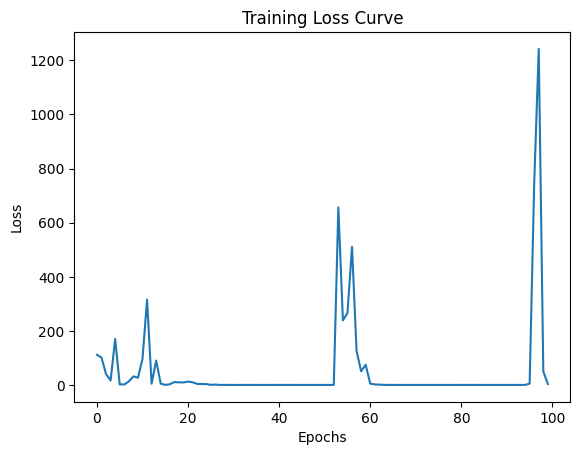

In [19]:
import matplotlib.pyplot as plt

plt.plot(loss_vals)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Convert test dataset to tensors
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)

# Set the model evaluation mode
model.eval()

# Disable gradients to pass through the NN
with torch.no_grad():
    output = model(X_test)

# Label the outputs in terms of their range
def label_output(value):
    if value <= -0.33:
        return -1
    elif value <= 0.33:
        return 0
    else:
        return 1

# Apply the custom labeling function to the model output
predictions = output.numpy().flatten()
predicted_labels = np.array([label_output(val) for val in predictions])

# Convert the true labels (y_test) to -1, 0, or 1
true_labels = y_test.numpy().flatten()
true_labels_labeled = np.array([label_output(val) for val in true_labels])

# Calculate accuracy
accuracy = accuracy_score(true_labels_labeled, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate loss on the test dataset
criterion = nn.MSELoss()
test_loss = criterion(output, y_test)
print(f"Test Loss (MSE): {test_loss.item():.4f}")

Test Accuracy: 38.98%
Test Loss (MSE): 3.7516


In [24]:
# How accurate is the move to a high-level player

pos = X_test[0]
true = y_test[0]

pos = pos.unsqueeze(0)

with torch.no_grad():
    output = model(pos)
    prediction = output

print(true)
print(prediction)

tensor([-1.])
tensor([[1.8060]])
